In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
#sang_번영1=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_번영농장_권현자(재배기간_2019.07.23~2020.06.10)/19-20작기_방울토마토_번영농장_권현자_생육1.xlsx')
sang_아리1=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_아리울_박문신(재배기간_2019.07.23~2020.06.30)/19-20작기_방울토마토_아리울_박문신_생육1.xlsx')
sang_하늘1=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_하늘농장_유철민(재배기간_2019.07.23~2020.06.28)/19-20작기_방울토마토_하늘농장_유철민_생육1.xlsx')
sang_화천1=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_화천농장_박성호(재배기간_2019.07.25~2020.06.30)/19-20작기_방울토마토_화천농장_박성호_생육1.xlsx')
sang_dataset=[]
#sang_dataset.append(sang_번영1)
sang_dataset.append(sang_아리1)
sang_dataset.append(sang_하늘1)
sang_dataset.append(sang_화천1)

In [4]:
sang_list=['아리1','하늘1','화천1']

In [55]:
#env_번영=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_번영농장_권현자(재배기간_2019.07.23~2020.06.10)/19-20작기_방울토마토_번영농장_권현자_환경(2019.09.07~2020.06.10).xlsx')
env_아리=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_아리울_박문신(재배기간_2019.07.23~2020.06.30)/19-20작기_방울토마토_아리울_박문신_환경(2019.07.23~2020.06.30).xlsx')
env_하늘=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_하늘농장_유철민(재배기간_2019.07.23~2020.06.28)/19-20작기_방울토마토_하늘농장_유철민_환경(2019.07.23~2020.06.28).xlsx')
env_화천=pd.read_excel('C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\19-20_방울토마토_화천농장_박성호(재배기간_2019.07.25~2020.06.30)/19-20작기_방울토마토_화천농장_박성호_환경(2019.07.25~2020.06.30).xlsx')
env_dataset=[]
#env_dataset.append(env_번영)
env_dataset.append(env_아리)
env_dataset.append(env_하늘)
env_dataset.append(env_화천)

In [56]:
## env Save pickle
'''
with open("C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\env_dataset.pickle","wb") as fw:
    pickle.dump(env_dataset, fw)
'''

In [6]:
## env Load pickle
with open("C:\\농업기술원\\1차\\2019\\19-20_방울토마토(4)\\env_dataset.pickle","rb") as fr:
    env_dataset = pickle.load(fr)


# 함수

In [7]:
# 주차 추가
def add_weeknum(sang_df):
    sang_df['diff']=sang_df['WeekNum'].shift(1)
    sang_df['diff2']=sang_df['WeekNum']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=0:
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [55]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)+timedelta(minutes=5)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)-timedelta(minutes=5)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [56]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [57]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['주차']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [58]:
def box_to_find_outlier(env_data,name,cols):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name)
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='주차',y=env)
        plt.title(name+'_'+env)
        plt.tight_layout()
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
        

In [119]:
def remove_outlier(df,col):
    cut_df=pd.DataFrame()
    for i in range(len(df['주차'].unique())):
        k=df[df['주차']==i+1]
        
        
        q1 = k[col].quantile(0.25)
        q3 = k[col].quantile(0.75)

        iqt = 1.5 * (q3 - q1)

        # 이상치 제거
        if iqt!=0:
            k=k[(k[col] < (q3 + iqt)) & (k[col] > (q1 - iqt))]
        
        cut_df=pd.concat([cut_df,k])
    return cut_df

In [60]:
def removed_outlier_pivot(df,col,aggfunc):
    cut_df=remove_outlier(df,col)
    result = cut_df.pivot_table(index='주차',
                               values=col,
                               aggfunc=aggfunc).reset_index(drop=False)

    return result

In [61]:
def pivot_lineplot(df,name,):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name)
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='주차',y=env)
        plt.title(name+'_'+env)
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')

----
# 1. 환경 요인 데이터셋 구성하기

- 누적일사량을 증가량으로 바꿔주기

- 이상치 파악하기

아리1


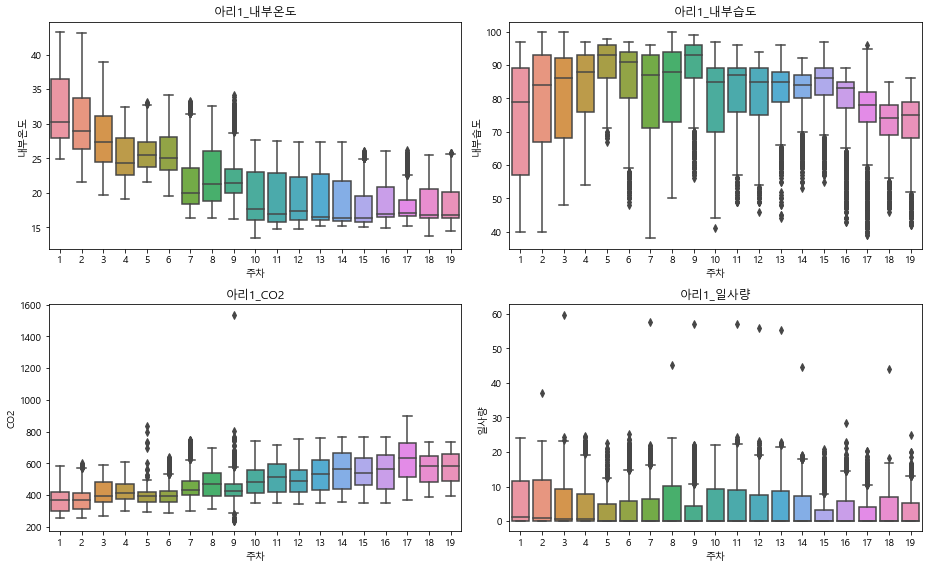

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
하늘1


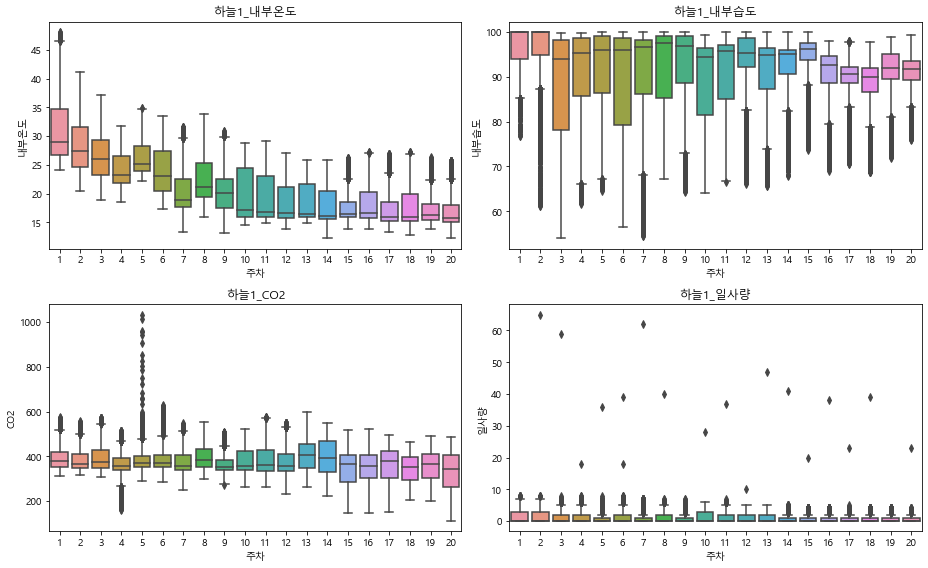

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
화천1


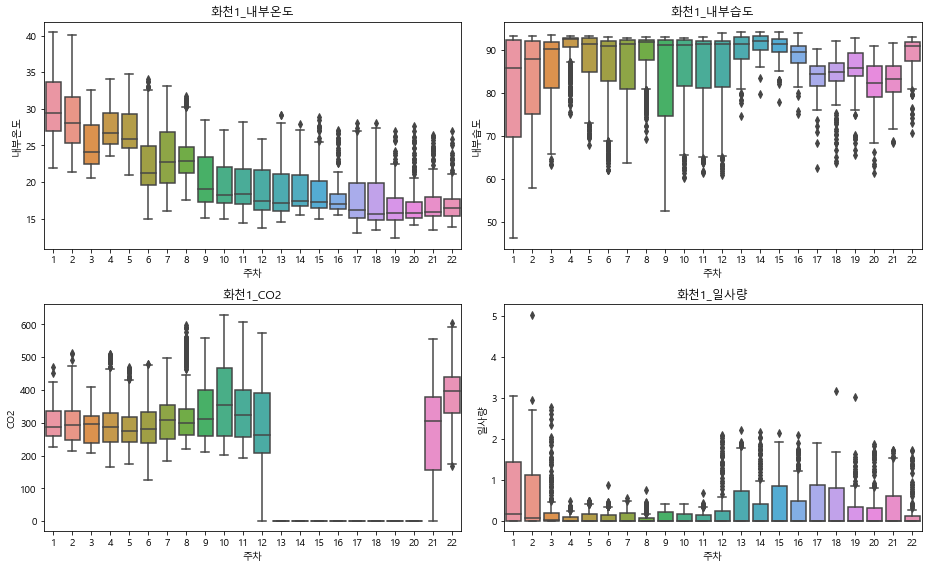

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [113]:
sang=[]
env=[]

for i in range(3):

    # 한 농장 sang 로드
    sang_col=['Date', 'WeekNum','Sample', '생장길이']
    sang_data = sang_dataset[i][sang_col]
    
    
    # 한 농장 env 로드
    env_col = ['date', '내부온도', '내부습도', 'CO2', '누적일사량']
    env_data = env_dataset[i][env_col]

    # 한 농장에 주차 추가
    sang_data['주차']=add_weeknum(sang_data)
    sang.append(sang_data)
    
    
    # 환경에 Date컬럼 추가, 12시기준 쪼개기
    생육조사기간=sorted(list(set(list(sang_data['Date']))))
    env_data=env_add_Date(env_data,생육조사기간)

    # 환경 데이터에 주차 컬럼 추가
    env_data['주차']=match_test_weeknum(sang_data,env_data)

    # 누적을 증가량으로 바꿔주기
    base_col=['date','Date','주차']
    cumsum_list=['누적일사량']
    cumsum_col=base_col+cumsum_list

    cumsum_df=cumsum_to_value(env_data[cumsum_col])
    env_data['일사량']=cumsum_df['일사량']
    del env_data['누적일사량']


    # 환경 데이터 변수명
    avg_list=['내부온도','내부습도','CO2']
    sum_list=['일사량']
    
    cols=avg_list+sum_list
    
    # 이상치 파악하기
    name=sang_list[i]
    box_to_find_outlier(env_data,name,cols)
    env_data=env_data.reset_index(drop=True)
    
    env.append(env_data)

전체적인 주차별 평균 환경 집계해서 한 그래프에 보여주기

온도 비교  습도비교

co2비교    일사량 비교

In [63]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['date','Date','주차']
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [64]:
# evn데이터 이상치 제거
pivot_set=[]
for nong in env:
    i=0
    for col,agg in zip(cols,aggfunc):
        df=nong[[col,'주차']]
        
        # 이상치 제거, 피봇
        my_pivot = removed_outlier_pivot(df,col,agg)
        
        
        if i==0:
            result = my_pivot
            i+=1
            continue
        
        result = pd.merge(result,my_pivot,how='inner',on='주차')
    pivot_set.append(result)

In [66]:
for i in range(len(sang_list)):
    pivot_set[i]['농가명']=sang_list[i]
    
pivot_set_concat = pd.concat(pivot_set)

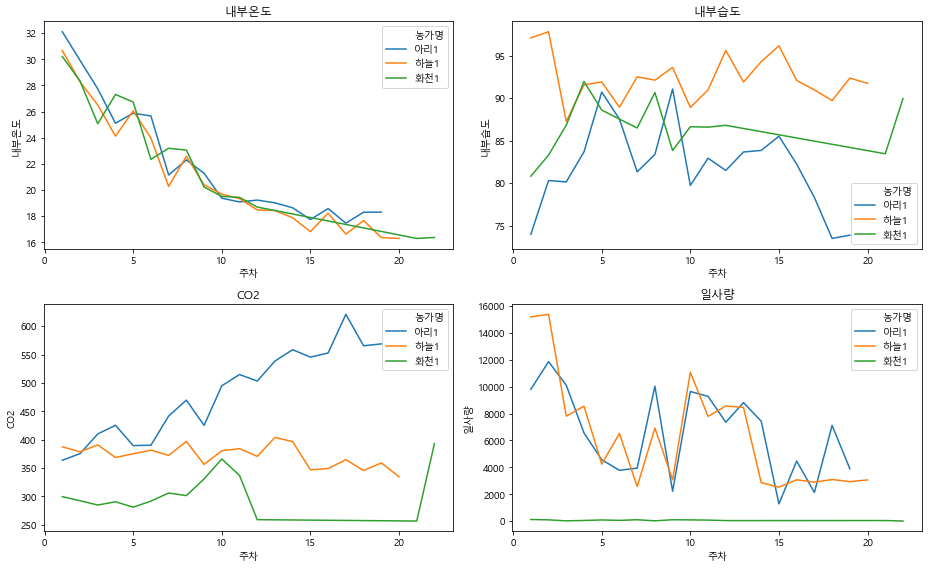

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [121]:

plt.figure(figsize=[13,8])
plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
cnt_cols = 2
cnt_rows = 2


for k,col in enumerate(cols):
    plt.subplot(cnt_rows, cnt_cols, k+1)
    sns.lineplot(data=pivot_set_concat,x='주차',y=col,hue='농가명')
    plt.title(col)
    plt.tight_layout()
plt.show()
print('---------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------')
    
    

시간 나눠서
0~7 7~12 12~19 19~24


In [115]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [143]:
# evn데이터 이상치 제거
time_set=[]
pivot_set_hour=[]


s_hour = [0,7,12,19]
e_hour = [6,11,18,23]
nong_name=0

for env_nong in env:
    time_set=[]
    
    for s,e in zip(s_hour,e_hour):
        nong = env_nong[(env_nong['date'].dt.hour>=s) & (env_nong['date'].dt.hour<=e)]
        i=0
        for col,agg in zip(cols,aggfunc):
            df=nong[[col,'주차']]

            # 이상치 제거, 피봇
            my_pivot = removed_outlier_pivot(df,col,agg)


            if i==0:
                result = my_pivot
                i+=1
                continue

            result = pd.merge(result,my_pivot,how='inner',on='주차')
        time_set.append(result)
        
        for i in range(len(time_set)):
            time_set[i]['농가명']=sang_list[nong_name]
    nong_name+=1    
    pivot_set_hour.append(time_set)
        
        
del nong
del result
del my_pivot
del df

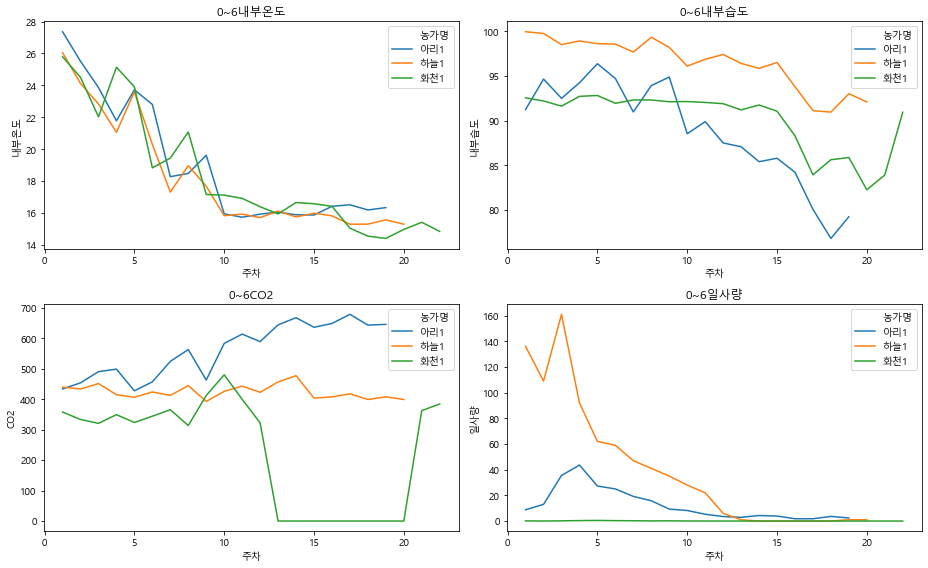

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


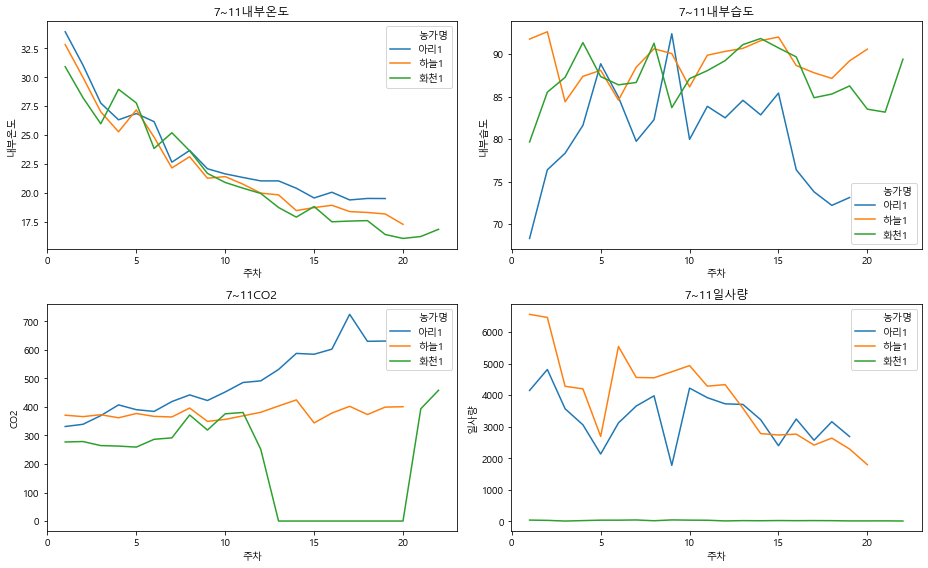

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


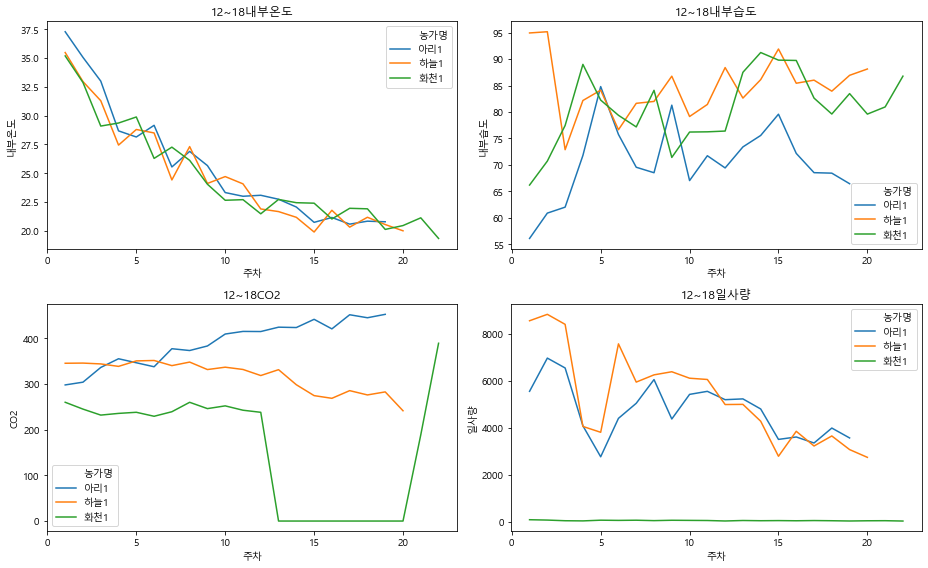

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


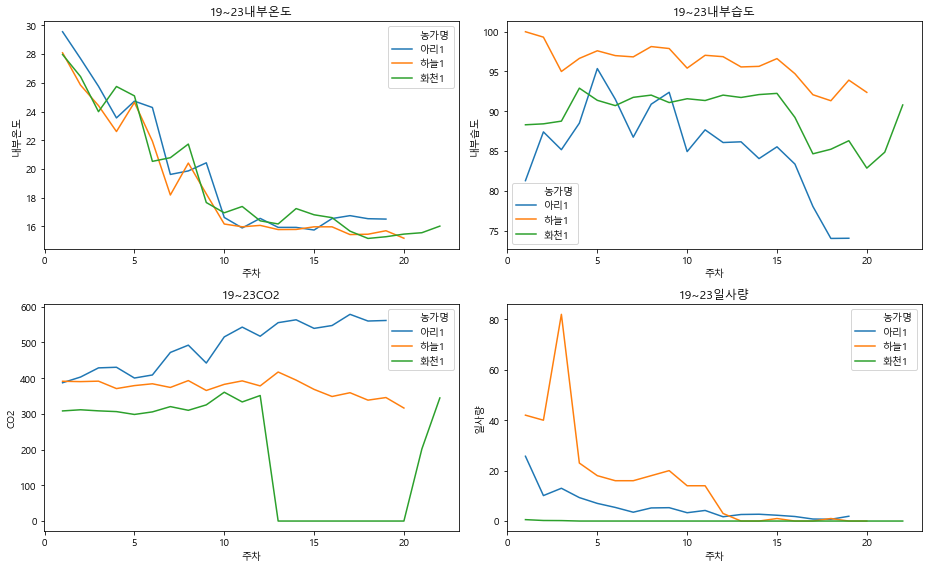

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [161]:



for h in range(len(s_hour)):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2
    pivot_set_concat = pd.concat([pivot_set_hour[0][h],pivot_set_hour[1][h],pivot_set_hour[2][h]])
    
    for i,col in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, i+1)
        sns.lineplot(data=pivot_set_concat,x='주차',y=col,hue='농가명')
        plt.title(str(s_hour[h])+'~'+str(end_hour[h])+str(cols[i]))
        plt.tight_layout()
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')


    
    

In [ ]:
화방번호별 초기 중기 안정기
1~5
6~11
12~